## **Traffic Sign Classifier Project**
**Introduction**

Imagine you are working as a Machine Learning Engineer for a transportation safety organization. Your task is to develop an application capable of analyzing and classifying traffic signs from images, enhancing road safety by assisting autonomous vehicles and driver-assistance systems in real-time.

**Business Scenario and Problem**

The organization aims to improve the accuracy and reliability of traffic sign recognition systems used in modern vehicles. They have collected a large dataset of traffic sign images but need an advanced machine learning model to automatically classify these signs into predefined categories such as speed limits, warnings, and prohibitions. As the data science expert, you are tasked with designing a classifier to achieve this goal effectively.

**Goals**

Your objectives in this project are to:

1. Explore and analyze the traffic sign dataset to understand its structure and diversity.
2. Develop a machine learning model capable of classifying traffic signs into appropriate categories.
3. Evaluate the model's performance to ensure its accuracy and reliability in real-world scenarios.
4. Present the machine learning model as a product to the non-technical stakeholders and the organization.
5. Provide recommendations on integrating the classifier into autonomous driving systems and its potential impact on improving road safety.

**Acknowledgment**

*Please note that this notebook has a research-educational, yet industrial purpose. The aim is to build a convolutional neural network from scratch, train it on a slightly different version of the original dataset and the architecture, and replicate the author's work.*

#### **Task 1. Imports and data loading**

We start by importing packages needed to build our machine learning model.

In [1]:
# Import packages for data manipulation
import numpy as np
import pandas as pd
import random
import pickle

# Import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import packages for building the model
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Dropout, Dense, Flatten)

# Import packages for data preprocessing and model performance
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, ConfusionMatrixDisplay, classification_report)

Now, clone the data from the GitHub repository and display its content.

In [2]:
# Clone the Data
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [3]:
# Get a list of available files
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


As shown above, we expect to have 4 files in a folder called `german-traffic-signs`. These include:
- A file for the names of the signs (i.e. associated classes ranging from 0-42).
- 3 **pickle** files for training, validation, and the test phase, respectively.

Now that we have a better understanding of the data, let's unpickle the sets to make them accessible.

In [4]:
# Unpickle the training set
with open('german-traffic-signs/train.p', 'rb') as train:
  train_data = pickle.load(train)

# Unpickle the validation set
with open('german-traffic-signs/valid.p', 'rb') as val:
  val_data = pickle.load(val)

# Unpickle the test set
with open('german-traffic-signs/test.p', 'rb') as test:
  test_data = pickle.load(test)

Each set contains X features and y labels, respectively. Separate the features from the target in all sets.

In [5]:
# Separate the features and target
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

Each image is mapped to a single label. Since the class names are not included with the dataset, store them here for later use when plotting the images. The names can be found in the `.csv` file.

In [6]:
# Store the class names in a list
sign_names = pd.read_csv('/content/german-traffic-signs/signnames.csv')
class_names = list(sign_names['SignName'])

# Iterate through the sign names and their associated class
names_dict = dict()
for index, name in enumerate(class_names):
  names_dict[index] = name
names_dict

{0: 'Speed limit (20km/h)',
 1: 'Speed limit (30km/h)',
 2: 'Speed limit (50km/h)',
 3: 'Speed limit (60km/h)',
 4: 'Speed limit (70km/h)',
 5: 'Speed limit (80km/h)',
 6: 'End of speed limit (80km/h)',
 7: 'Speed limit (100km/h)',
 8: 'Speed limit (120km/h)',
 9: 'No passing',
 10: 'No passing for vechiles over 3.5 metric tons',
 11: 'Right-of-way at the next intersection',
 12: 'Priority road',
 13: 'Yield',
 14: 'Stop',
 15: 'No vechiles',
 16: 'Vechiles over 3.5 metric tons prohibited',
 17: 'No entry',
 18: 'General caution',
 19: 'Dangerous curve to the left',
 20: 'Dangerous curve to the right',
 21: 'Double curve',
 22: 'Bumpy road',
 23: 'Slippery road',
 24: 'Road narrows on the right',
 25: 'Road work',
 26: 'Traffic signals',
 27: 'Pedestrians',
 28: 'Children crossing',
 29: 'Bicycles crossing',
 30: 'Beware of ice/snow',
 31: 'Wild animals crossing',
 32: 'End of all speed and passing limits',
 33: 'Turn right ahead',
 34: 'Turn left ahead',
 35: 'Ahead only',
 36: 'Go st

#### **Task 2. Exploratory Data Analysis (EDA)**

Let's explore the shape of the dataset:

In [7]:
# Display the shape of the datasets
print(f'Shape of the Training set: {X_train.shape, y_train.shape}')
print(f'Shape of the Validation set: {X_val.shape, y_val.shape}')
print(f'Shape of the Test set: {X_test.shape, y_test.shape}')

Shape of the Training set: ((34799, 32, 32, 3), (34799,))
Shape of the Validation set: ((4410, 32, 32, 3), (4410,))
Shape of the Test set: ((12630, 32, 32, 3), (12630,))


Now, let's plot a set of images to see what they look like.

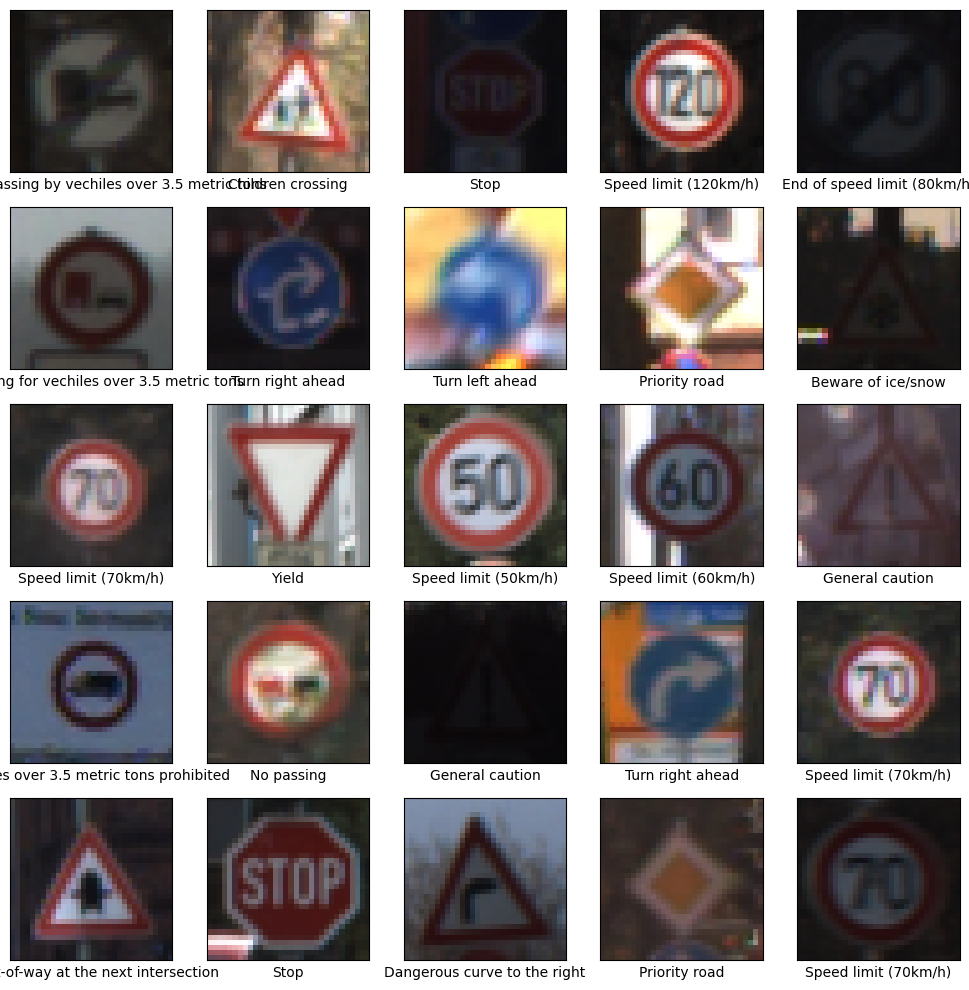

In [8]:
# Display 25 random images from the training set and display the class name below each image
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  idx = random.randint(0, len(X_train) - 1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(X_train[idx])
  plt.xlabel(class_names[y_train[idx]])
plt.tight_layout()
plt.show();

Finally, let's plot the distribution of the labels to check the class balance and gain a deeper understanding of the labels.

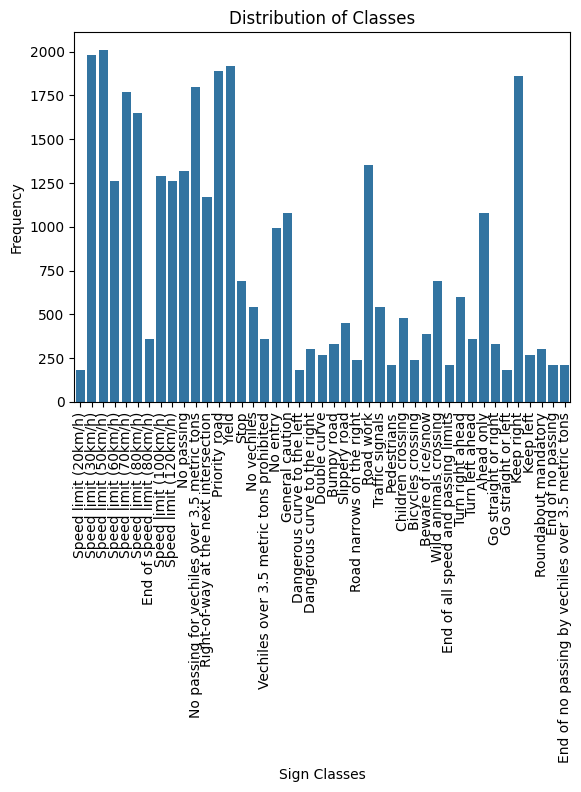

In [9]:
# Plot the distribution of the classes
plt.title('Distribution of Classes')
plt.xlabel('Sign Classes')
plt.ylabel('Frequency')
sns.countplot(x=y_train)
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=90)
plt.show();

**Interpretations:**

- The graph clearly indicates that the distribution of the data is imbalanced. For instance, the first class (Speed limit 20 km/h) has the lowest number of samples; whereas the third class (Speed limit 50 km/h) has the maximum.

- A rule-of-thumb conclusion from this interpretation is that the model would perform exceptionally well on images from this class (Speed limit 50 km/h), but we should also consider something else: *The quality of the images.* Although the number of samples in the first class may be smaller compared to others, the quality of the data in that specific class is crucial. It could be significantly better than the quality of images in the fifth class, despite having fewer samples.

- From another perspective, this class imbalance would probably affect the model performance, so we need to take an approach called **Data Augmentation**. That is, generating more training data from existing training samples by augmenting the samples via several random transformations that yield believable-looking images. The goal is that at training time, the model will never see the exact same picture twice. This helps expose the model to more aspects of the data and generalize better.

But before that, let's do some preprocessing on our data.

#### **Task 3. Data Preprocessing**

We've seen that our data contains RGB images with 3 channels. Also, the intensity of the colors in each image is different, which might affect the quality of the images. So to preprocess the data, we're going to:

- Convert RGB  images to Grayscale
- Improve and adjust the contrast
- Normalize the images

The second task can be done using something called *Histogram Equalization*: An algorithm that uses the image's histogram to determine a transform and adjust contrast.

Let's write a function that applies all the 3 mentioned transformations to the images:

In [10]:
# Function for preprocessing the images
def preprocess(img):
  img = cv2.resize(img, (32, 32))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.equalizeHist(img)
  img = np.divide(img, 255)
  return img

Apply the transformations to the images and display one of the preprocessed images.

In [11]:
# Apply the preprocessing to the images
X_train = np.array(list(map(preprocess, X_train)))
X_val = np.array(list(map(preprocess, X_val)))
X_test = np.array(list(map(preprocess, X_test)))

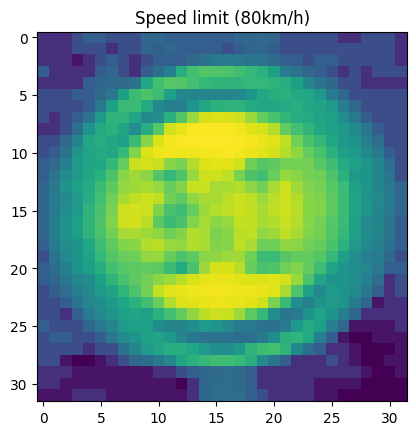

In [12]:
# Display a sample of the preprocessed images
idx = random.randint(0, len(X_train) - 1)
plt.imshow(X_train[idx])
plt.title(class_names[y_train[idx]])
plt.show();

Our data is approximately ready for the augmentation phase. One last note is that, for image augmentation, we're going to use ImageDataGenerator, which expects a 4D array for images with a shape (num_samples, height, width, channels). The train, validation, and test images should include a channel dimension, even if they're grayscale. Therefore, we need to reshape the data to ensure it has the appropriate format.

In [13]:
# Reshape train, validation and test images to add a channel dimension
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

print(f'Shape of the Training-set after reshaping: {X_train.shape}')
print(f'Shape of the Validation-set after reshaping: {X_val.shape}')
print(f'Shape of the Testing-set after reshaping: {X_test.shape}')

Shape of the Training-set after reshaping: (34799, 32, 32, 1)
Shape of the Validation-set after reshaping: (4410, 32, 32, 1)
Shape of the Testing-set after reshaping: (12630, 32, 32, 1)


We also need to convert the target variable into a categorical variable. Let's first check the length of the target variable in all our 3 sets.

In [14]:
# Make sure all sets have a consistent target shape
len(np.unique(y_train)) == len(np.unique(y_val)) == len(np.unique(y_test))

True

In [15]:
# One-Hot Encode the target variable
n_classes = len(np.unique(y_train))

y_train = tf.keras.utils.to_categorical(y_train, n_classes)
y_val = tf.keras.utils.to_categorical(y_val, n_classes)
y_test = tf.keras.utils.to_categorical(y_test, n_classes)

#### **Data Augmentation**

Now it's time to augment data. To start off, let's define a function that can display an image, so we can see the type of augmentation that has been performed. Then, we'll look at specific augmentations that we'll use during training.

In [16]:
# Function to plot images in the form of a grid with 1 row and 5 columns where images are placed in each column
def plotImages(images_arr):
  fig, axes = plt.subplots(1, 5)
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img, cmap=plt.cm.binary)
  plt.tight_layout()
  plt.show();

Now create a data augmentation object and then apply it to the training set. Apply rotation of 10 degrees, width shift, height shift, and zoom augmentation to our training images.

In [17]:
# Create a transformation object
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest'
)

# Apply the transformations to the training set
datagen.fit(X_train)

Let's visualize how 5 random images would look like, when we pass these augmentations randomly to our dataset.

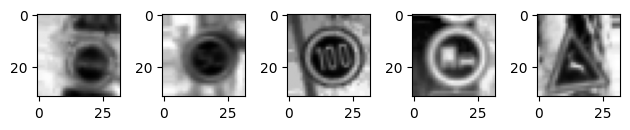

In [18]:
# Generate a batch of augmented images
augmented_images = [datagen.random_transform(X_train[random.randint(0, len(X_train) - 1)]) for i in range(5)]

# Plot the augmented images
plotImages(augmented_images)

Technically, we don't apply the transformations to the test-validation sets. We leave the test set untouched and apply the validation data just with the purpose of testing the performance of the model during the training process.

#### **Task 4. Build the model**

We start by building a modified version of LeNet from scratch. LeNet-5 was one of the earliest convolutional neural networks proposed by Yann LeCun and others in the year 1998, and was historically important during the development of deep learning. This modified version comes from the papers:
1. <a href='https://ieeexplore.ieee.org/document/6033589'>Traffic sign recognition with multi-scale Convolutional Networks</a>
2. <a href='https://odr.chalmers.se/server/api/core/bitstreams/fdef1142-92cb-4f8c-9c8a-f17f72260c00/content'>Traffic sign classification with deep convolutional neural networks</a>.

Its architecture:

### Sermanet & LeCun Architecture
- Input ($32$x$32$, grayscale)<br>
Conv ($5$x$5$, $108$ maps)<br>
Nonlinearity ($ReLU$)<br>
Max-pooling ($2$x$2$)<br>

- Conv ($5$x$5$, $108$ maps)<br>
Nonlinearity ($ReLU$)<br>
Max-pooling ($2$x$2$)<br>

- Fully-conn. ($100$ units)<br>
Nonlinearity ($ReLU$)<br>
Fully-conn. ($100$ units)<br>
Nonlinearity ($ReLU$)<br>
Fully-conn. ($43$ units)<br>
Softmax

If you want to learn more about the architecture and its activation function, please check the two papers mentioned above.

In [19]:
# Define the parameters
shape = X_train.shape[1:]
classes = n_classes

In [20]:
# Build the model
def neural_network(input_shape, n_classes):

  # Input layer
  X_input = Input(input_shape)

  # First conv layer
  X = Conv2D(108, kernel_size=(5, 5), activation='relu')(X_input)
  X = MaxPooling2D(pool_size=(2, 2))(X)
  X = Dropout(0.15)(X)

  # Second conv layer
  X = Conv2D(108, kernel_size=(5, 5), activation='relu')(X)
  X = MaxPooling2D(pool_size=(2, 2))(X)
  X = Dropout(0.2)(X)

  # FC & Output layers
  X = Flatten()(X)
  X = Dense(100, activation='relu')(X)
  X = Dense(100, activation='relu')(X)
  X = Dense(n_classes, activation='softmax')(X)

  # Build the model
  model = Model(inputs=X_input, outputs=X, name='Network')
  return model

In [21]:
# Call the model
model = neural_network(shape, classes)

#### **Task 5. Compile the model**

Before the model is ready for training, it needs a few more settings. We would set the "Loss function" to be `Categorical Crossentropy`, the "Optimizer" to be `Adam`, and the "Metrics" to be `Accuracy`. Note that we use categorical crossentropy because we already converted the target variable into a categorical variable. Otherwise, we would use `Sparse Categorical Crossentropy`.


In [22]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display the number of parameters
model.summary()

Model: "Network"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 108)         │           2,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 108)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 108)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 10, 10, 108)         │         291,708 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 108)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5, 5, 108)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2700)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │         270,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 43)                  │           4,343 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 579,059 (2.21 MB)

 Trainable params: 579,059 (2.21 MB)

 Non-trainable params: 0 (0.00 B)

#### **Task 6. Train the model**

We'll continue our process with training the model using the augmented train images. We will also utilize the normalized validation data to evaluate the model's performance during training.

In [23]:
# Train the model using the generator
epochs = 15
history = model.fit(datagen.flow(X_train, y_train, batch_size=128),
                    validation_data=(X_val, y_val),
                    epochs=epochs, shuffle=True)

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


272/272 ━━━━━━━━━━━━━━━━━━━━ 29s 72ms/step - accuracy: 0.1805 - loss: 3.0589 - val_accuracy: 0.7481 - val_loss: 0.8952
Epoch 2/15
272/272 ━━━━━━━━━━━━━━━━━━━━ 31s 53ms/step - accuracy: 0.6688 - loss: 1.0714 - val_accuracy: 0.8476 - val_loss: 0.4617
Epoch 3/15
272/272 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.7996 - loss: 0.6581 - val_accuracy: 0.8943 - val_loss: 0.3338
Epoch 4/15
272/272 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - accuracy: 0.8520 - loss: 0.4587 - val_accuracy: 0.9349 - val_loss: 0.2199
Epoch 5/15
272/272 ━━━━━━━━━━━━━━━━━━━━ 14s 51ms/step - accuracy: 0.8948 - loss: 0.3430 - val_accuracy: 0.9531 - val_loss: 0.1691
Epoch 6/15
272/272 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.9164 - loss: 0.2792 - val_accuracy: 0.9633 - val_loss: 0.1333
Epoch 7/15
272/272 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - accuracy: 0.9291 - loss: 0.2292 - val_accuracy: 0.9603 - val_loss: 0.1297
Epoch 8/15
272/272 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.9357 - loss: 0.2049 - val_accurac

**Results:**

- Training-set: The model performs well on the training data, with a high accuracy and relatively low loss.

- Validation-set: The validation accuracy and loss are very close to the training metrics, indicating that the model is learning well from the training data and is not overfitting.

#### **Task 7. Plot the Accuracies and Losses**

Let's plot the loss and accuracy between the two train-validation sets and analyze them to gain a deeper understanding of whether they are overfitting or not. We should extract the two from the dictionary saved in the `history` variable.

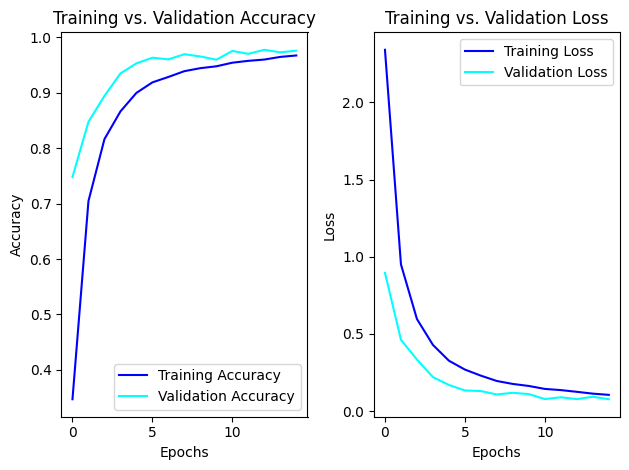

In [24]:
# Extract the loss and accuracy from the dictionary and plot them
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', color='blue')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='cyan')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', color='blue')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='cyan')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.tight_layout()
plt.show();

**Interpretation of Graphs**

It's important to understand that the number of batch sizes significantly affects reducing loss per epoch. The small zigzags occur because we're using Mini-Batch Gradient Descent. A lower batch size can cause more noise for our model to detect, which can make learning less effective. On the other hand, a higher batch size can speed up convergence and reduce noise. For this specific model, a batch size of $128$ seems like a good choice because it not only speeds up convergence but also leads to a smoother curve.

#### **Task 8. Plot Predictions**

Let's write a function that makes predictions on the validation-test sets and displays them alongside their true label.

In [25]:
# Function to display the predicted images
def display_predictions(model, X_data, y_data, n=None, color=None):

  # Make predictions
  predicted_labels = model.predict(X_data)

  # Converts predictions & true labels to class indices
  predicted_labels = np.argmax(predicted_labels, axis=1)
  true_labels = np.argmax(y_data, axis=1)

  plt.figure(figsize=(10, 10))
  for i in range(n):
    plt.subplot(5,5,i+1)
    idx = random.randint(0, len(X_data) - 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_data[idx], cmap=color)
    true_label = true_labels[idx]
    predicted_label = predicted_labels[idx]
    plt.title(f'True: {true_label}, Pred: {predicted_label}')

  plt.tight_layout()
  plt.show();

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


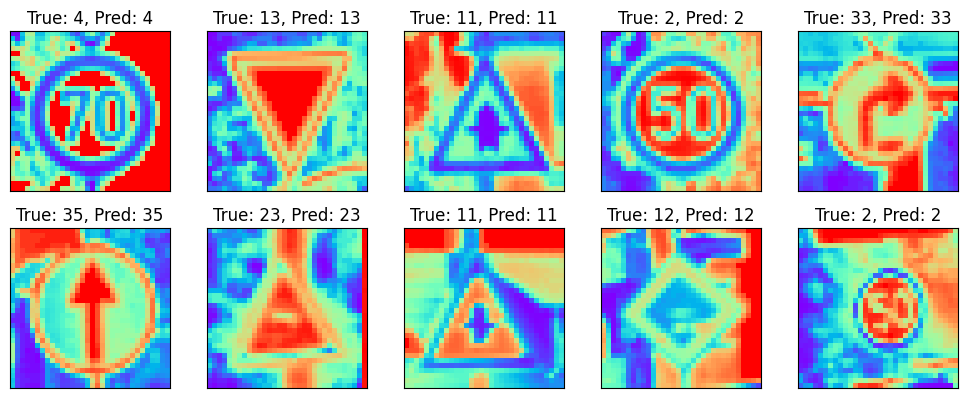

In [26]:
# Display a few couple of predictions from the validation set
display_predictions(model, X_val, y_val, n=10, color='rainbow')

#### **Task 9. Analysis of Model Performance on Test Data**

It's time to compare how the model performs on the test dataset. We use all examples we have in the test dataset to assess accuracy.

In [27]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test)

print(f'Accuracy on test dataset: {accuracy:.4}')
print(f'Loss on test dataset: {loss:.4}')

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9530 - loss: 0.1929
Accuracy on test dataset: 0.9517
Loss on test dataset: 0.1847


The model's test accuracy and loss are a bit lower than the metrics for training and the validation sets. This suggests that the model is performing well on new data, although there might be still room for improvement or just natural variation between the datasets.

We're going to analyze the model performance on the test set by making predictions and comparing them with the true labels to get the number of wrong predictions. We'll then display the ratio using a confusion matrix, and get a `classification report` of the class scores.

In [28]:
# Initialize a list to track correctness
correct_predictions = []

# Make predictions on the test data
predictions = model.predict(X_test)

# Display the first 10 random predictions along with their true labels
n = 10
for i in range(n):
    y_pred, y_true = np.argmax(predictions[i]), np.argmax(y_test[i])
    correct_predictions.append(y_pred == y_true)
    print(f'Pred: {class_names[y_pred]} , Actual: {class_names[y_true]}')

# Calculate accuracy for the first 10 images
accuracy = np.mean(correct_predictions) * 100
print('--------------------------------------------------------')
print(f'The Accuracy on the first {n} images: {accuracy}%')

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Pred: Vechiles over 3.5 metric tons prohibited , Actual: Vechiles over 3.5 metric tons prohibited
Pred: Speed limit (30km/h) , Actual: Speed limit (30km/h)
Pred: Keep right , Actual: Keep right
Pred: Turn right ahead , Actual: Turn right ahead
Pred: Right-of-way at the next intersection , Actual: Right-of-way at the next intersection
Pred: Keep right , Actual: Keep right
Pred: General caution , Actual: General caution
Pred: Priority road , Actual: Priority road
Pred: Road work , Actual: Road work
Pred: Ahead only , Actual: Ahead only
--------------------------------------------------------
The Accuracy on the first 10 images: 100.0%


In [29]:
# Convert ground truth & predictions from one-hot encoding to class indices
predictions = np.argmax(predictions, axis=1)
ground_truth = np.argmax(y_test, axis=1)

# Compute the number of wrong predictions
num_wrong_predictions = np.sum(predictions != ground_truth)

print(f'Number of wrong predictions: {num_wrong_predictions}')

Number of wrong predictions: 610


610 out of 12630 (an error rate of about $0.05$) is a perfect ratio of the wrong predictions. But this indicates that there's still room for improvement.

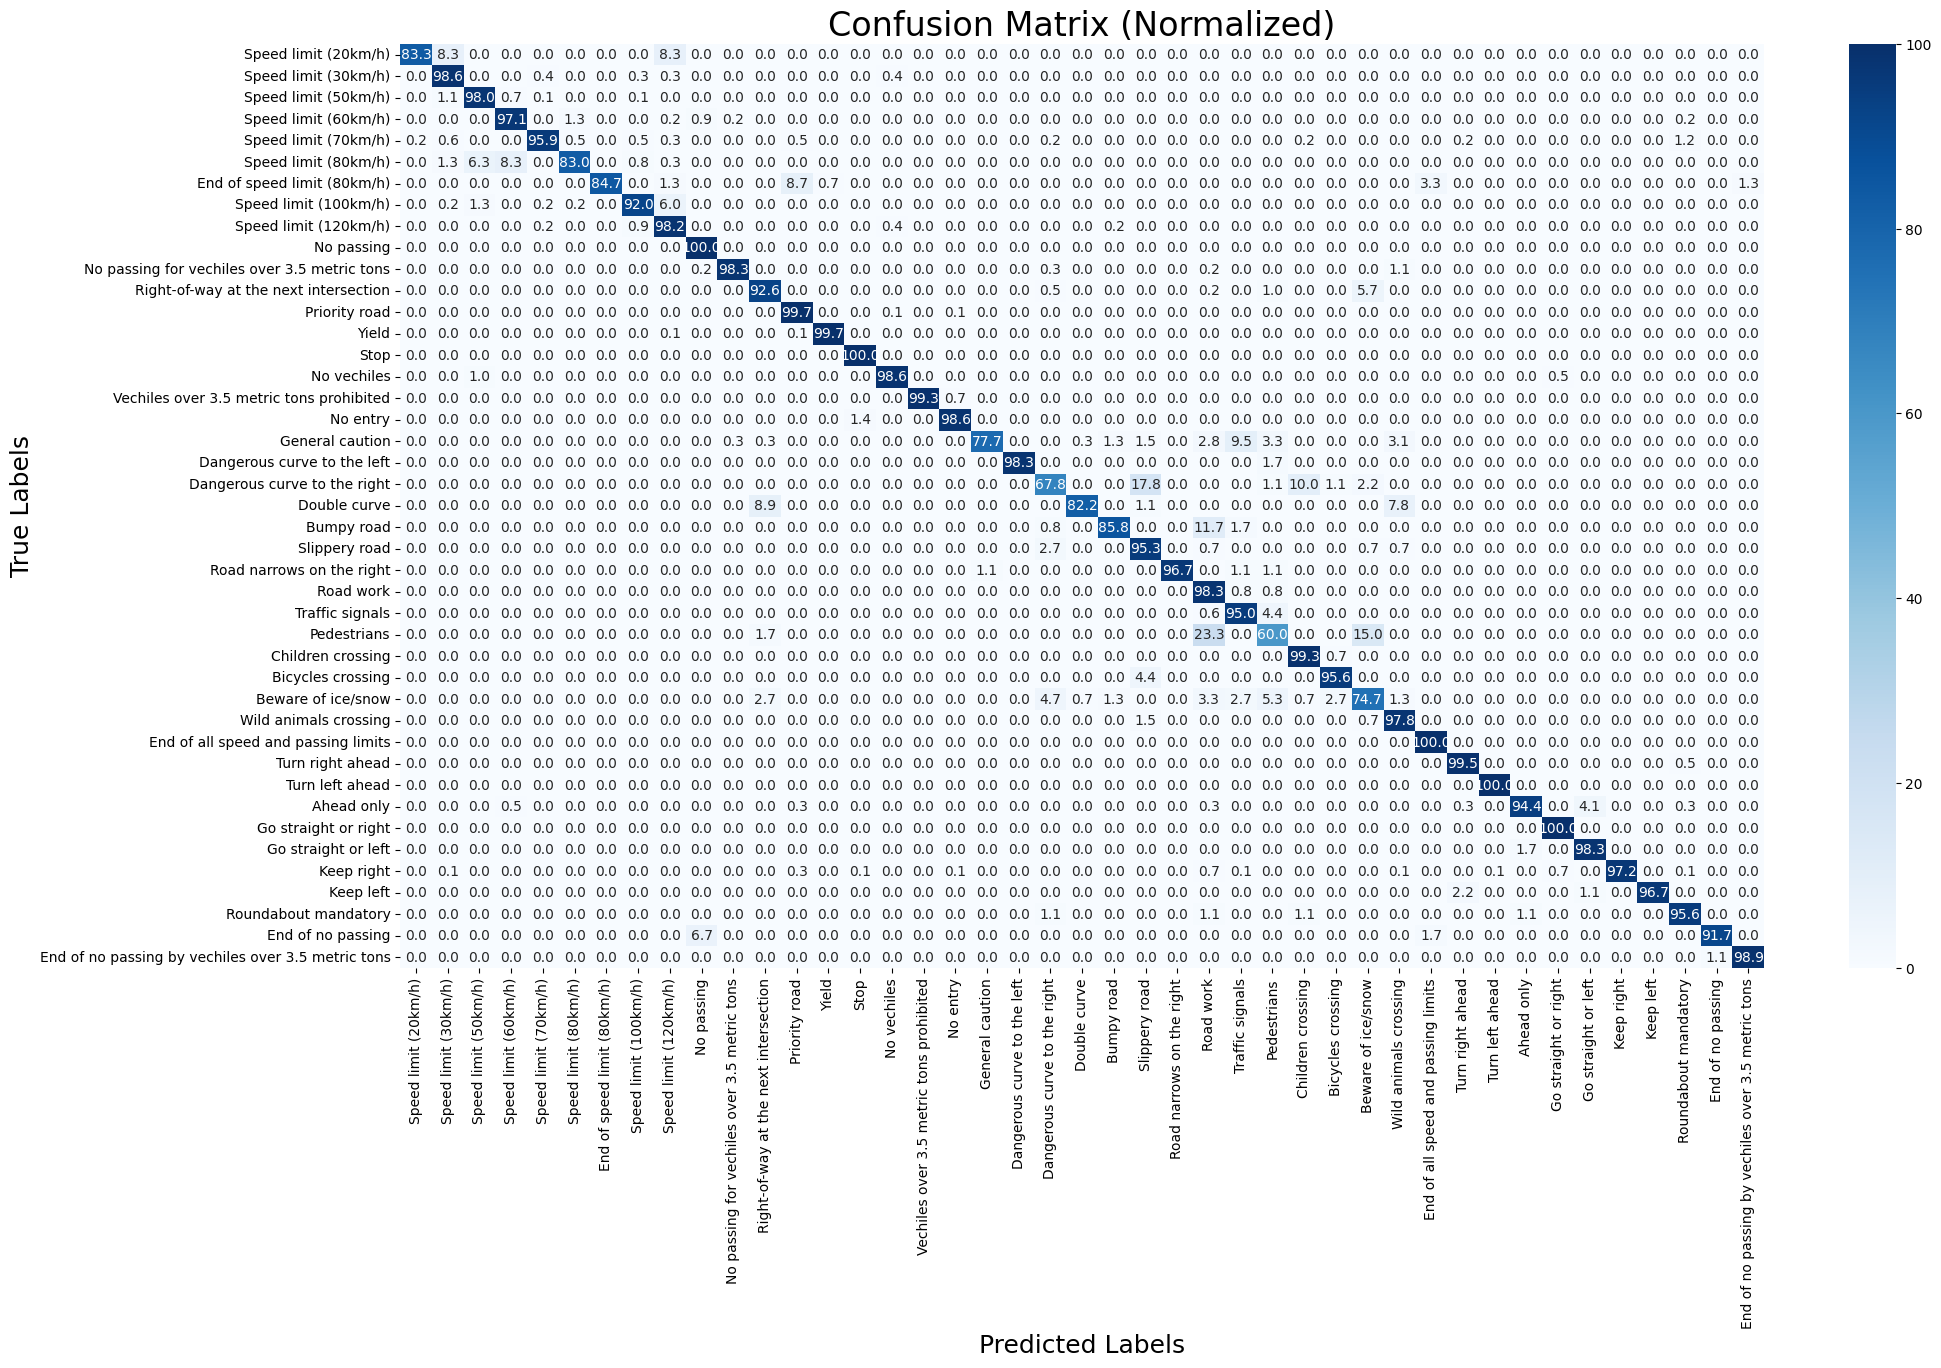

In [30]:
# Create a confusion matrix to analyze the performance of the model
cm = confusion_matrix(ground_truth, predictions)

# Normalize the confusion matrix to show percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot the confusion matrix
plt.figure(figsize=(22, 12))
sns.heatmap(cm_percentage, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix (Normalized)', fontsize=24)
plt.xlabel('Predicted Labels', fontsize=18)
plt.ylabel('True Labels', fontsize=18)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show();

This normalized confusion matrix shows the **Recall** score of each class. In general, the model performance is acceptable, except for some of the classes such as "Pedestrians", which has a high rate of incorrect predictions (about 60% predicted correctly).

In [31]:
# Get a report of metrics on different classes
print(classification_report(ground_truth, predictions,
                            target_names=class_names))

                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       0.98      0.83      0.90        60
                              Speed limit (30km/h)       0.96      0.99      0.97       720
                              Speed limit (50km/h)       0.94      0.98      0.96       750
                              Speed limit (60km/h)       0.88      0.97      0.92       450
                              Speed limit (70km/h)       0.99      0.96      0.97       660
                              Speed limit (80km/h)       0.98      0.83      0.90       630
                       End of speed limit (80km/h)       1.00      0.85      0.92       150
                             Speed limit (100km/h)       0.97      0.92      0.94       450
                             Speed limit (120km/h)       0.91      0.98      0.95       450
                                        No passing       0.98      1.00      0.

As discussed before, "Speed limit 20km/h" has the lowest number of samples, but it performed exceptionally well. It supported 60 of the images and achieved a precision score of 98%, which is extremely better than the class "Pedestrians" with the same amount of supports.

#### **Task 10. Making & Visualizing Predictions**

Since the model performed well on the test set, we will now proceed to make predictions and visualize them. This will provide us with a clearer overview of the model's confidence in each prediction.

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


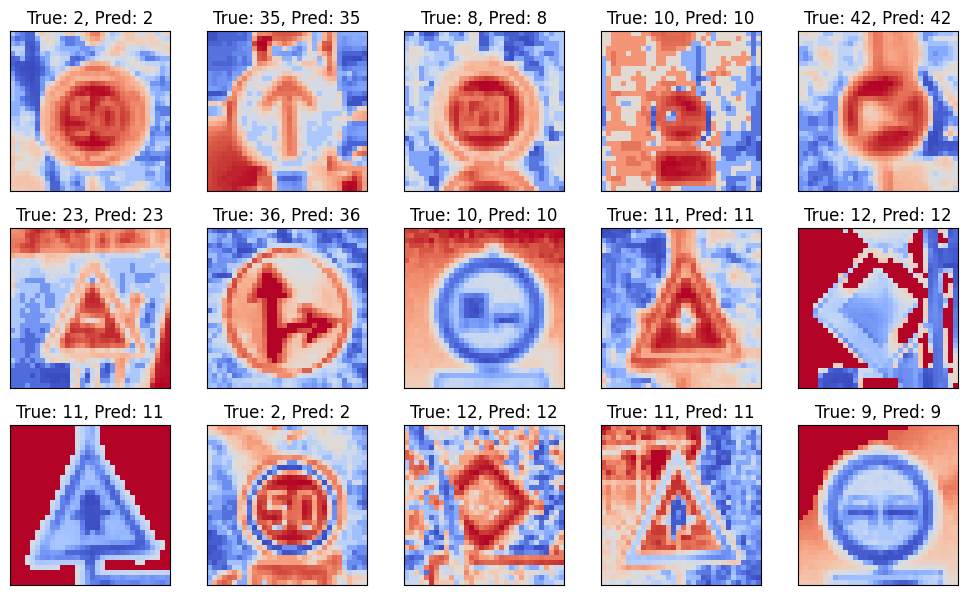

In [32]:
# Call the function to display predicted test images
display_predictions(model, X_test, y_test, n=15, color='coolwarm')

The visualization of the test predictions looks astonishing. No images were classified incorrectly! Let's save the model so that we can use it in the application.

In [33]:
# Save the model
clf = model.save('classifier.h5')